In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import ttest_ind

In [57]:
data=pd.read_csv('QVI_transaction_data.csv')
customers=pd.read_csv('QVI_purchase_behaviour.csv')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [61]:
data['DATE']=pd.to_datetime(data['DATE'],origin='1900-01-01',unit='D')
data['DATE']

0        2018-10-19
1        2019-05-16
2        2019-05-22
3        2018-08-19
4        2018-08-20
            ...    
264831   2019-03-11
264832   2018-08-15
264833   2018-11-08
264834   2018-12-29
264835   2018-09-24
Name: DATE, Length: 264836, dtype: datetime64[ns]

In [63]:
result = data.groupby('PROD_NAME').size().reset_index(name='Count')
result

,PROD_NAME,Count
0,Burger Rings 220g,1564
1,CCs Nacho Cheese 175g,1498
2,CCs Original 175g,1514
3,CCs Tasty Cheese 175g,1539
4,Cheetos Chs & Bacon Balls 190g,1479
...,...,...
109,WW Sour Cream &OnionStacked Chips 160g,1483
110,WW Supreme Cheese Corn Chips 200g,1509
111,Woolworths Cheese Rings 190g,1516
112,Woolworths Medium Salsa 300g,1430


In [69]:
#### Examine the words in PROD_NAME to see if there are any incorrect entries
#### such as products that are not chips
unique_prod_names = data['PROD_NAME'].unique()
words = [word for name in unique_prod_names for word in name.split()]
productWords = pd.DataFrame(words, columns=['words'])

print(productWords)

           words
0        Natural
1           Chip
2         Compny
3    SeaSalt175g
4            CCs
..           ...
584         150g
585      Doritos
586        Salsa
587         Mild
588         300g

[589 rows x 1 columns]


In [137]:
# Filter out rows where 'words' contain numbers
productWords = productWords[~productWords['words'].str.contains(r'\d')]
productWords = productWords[productWords['words'].str.contains(r'[a-zA-Z]')]

word_count = productWords['words'].value_counts().reset_index()
word_count.columns = ['words', 'count']
word_count = word_count.sort_values(by='count', ascending=False)

# Display the result
print(word_count)

               words  count
0              Chips     21
1             Smiths     16
2            Crinkle     14
3                Cut     14
4             Kettle     13
..               ...    ...
104            Balls      1
103              Slt      1
102           Vingar      1
101  SourCream&Herbs      1
188        Bolognese      1

[189 rows x 2 columns]


In [73]:
data.describe(include='all')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,264836,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836,264836.000000,264836.000000
unique,NaN,NaN,NaN,NaN,NaN,114,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2019-01-01 00:52:12.879215616,135.08011,1.355495e+05,1.351583e+05,56.583157,NaN,1.907309,7.304200
min,2018-07-03 00:00:00,1.00000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.500000
25%,2018-10-02 00:00:00,70.00000,7.002100e+04,6.760150e+04,28.000000,NaN,2.000000,5.400000
50%,2019-01-01 00:00:00,130.00000,1.303575e+05,1.351375e+05,56.000000,NaN,2.000000,7.400000
75%,2019-04-02 00:00:00,203.00000,2.030942e+05,2.027012e+05,85.000000,NaN,2.000000,9.200000
max,2019-07-02 00:00:00,272.00000,2.373711e+06,2.415841e+06,114.000000,NaN,200.000000,650.000000


In [75]:
#### Filter the dataset to find the outlier
outlier=data[data['PROD_QTY']==200]
outlier

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-21,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-22,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [76]:
# let's see if the customer has had other transactions
customer=data[data['LYLTY_CARD_NBR']==226000]
customer

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-21,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-22,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [79]:
#### Filter out the customer based on the loyalty card number
filterdata=data[data['LYLTY_CARD_NBR']!=226000]
filterdata

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-19,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-16,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-22,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-19,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-20,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-11,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-15,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-08,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-29,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [81]:
data.describe(include='all')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,264836,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836,264836.000000,264836.000000
unique,NaN,NaN,NaN,NaN,NaN,114,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2019-01-01 00:52:12.879215616,135.08011,1.355495e+05,1.351583e+05,56.583157,NaN,1.907309,7.304200
min,2018-07-03 00:00:00,1.00000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.500000
25%,2018-10-02 00:00:00,70.00000,7.002100e+04,6.760150e+04,28.000000,NaN,2.000000,5.400000
50%,2019-01-01 00:00:00,130.00000,1.303575e+05,1.351375e+05,56.000000,NaN,2.000000,7.400000
75%,2019-04-02 00:00:00,203.00000,2.030942e+05,2.027012e+05,85.000000,NaN,2.000000,9.200000
max,2019-07-02 00:00:00,272.00000,2.373711e+06,2.415841e+06,114.000000,NaN,200.000000,650.000000


In [83]:
 # Count the number of transactions by date
data_counts=data.groupby('DATE').size().reset_index(name='Transaction_Counts')
data_counts

,DATE,Transaction_Counts
0,2018-07-03,724
1,2018-07-04,711
2,2018-07-05,722
3,2018-07-06,714
4,2018-07-07,712
...,...,...
359,2019-06-28,723
360,2019-06-29,709
361,2019-06-30,730
362,2019-07-01,745


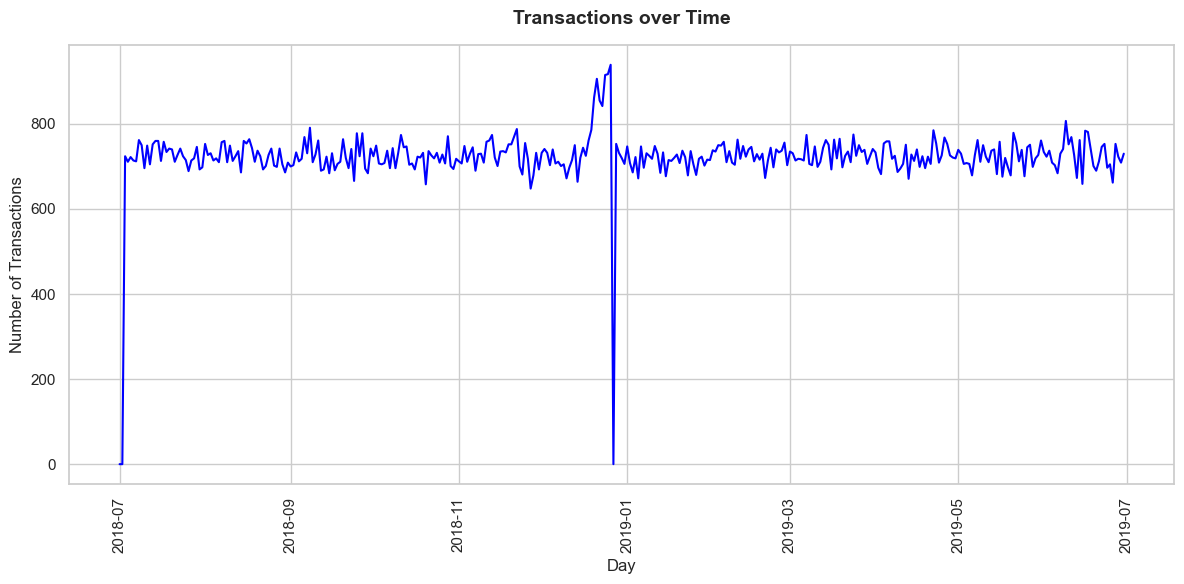

In [85]:
#Create a sequence of dates and join this the count of transactions by date
allDates = pd.DataFrame({
    'DATE': pd.date_range(start='2018-07-01', end='2019-06-30')
})

data_by_date = data.groupby('DATE').size().reset_index(name='N')
data_by_day = pd.merge(allDates, data_by_date, on='DATE', how='left')
data_by_day['N'] = data_by_day['N'].fillna(0).astype(int)
sns.set_theme(style="whitegrid")

# Step 6: Plot transactions over time
plt.figure(figsize=(12, 6))
plt.plot(data_by_day['DATE'], data_by_day['N'], color='blue', linestyle='-', label='Transactions')

# Step 7: Customize the plot
plt.title("Transactions over Time", fontsize=14, weight='bold', pad=15)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


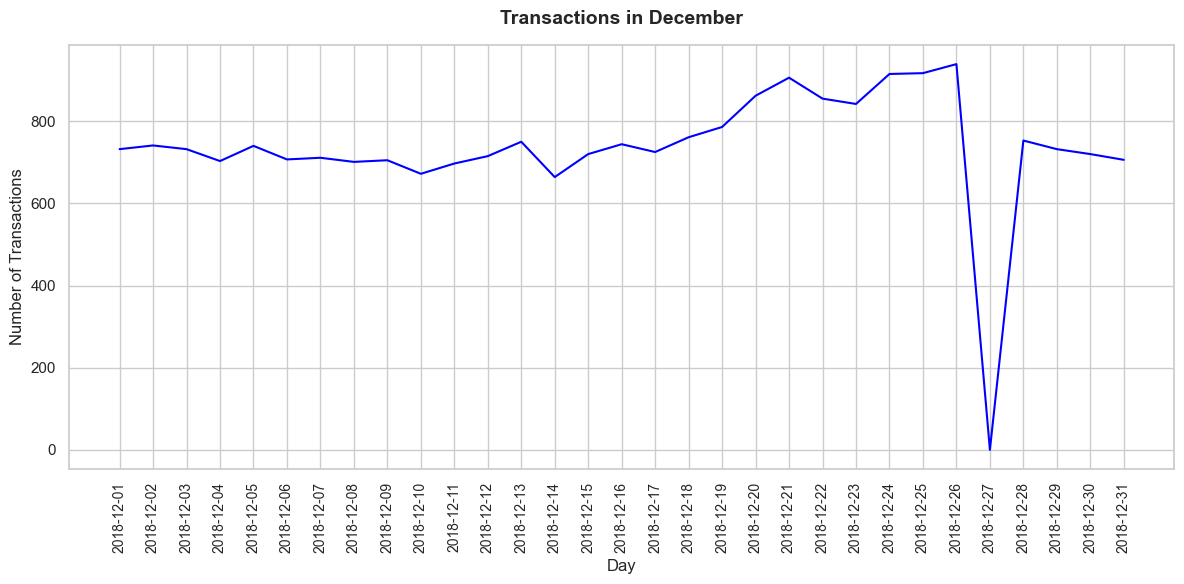

In [87]:
# Ensure DATE is a datetime object
data_by_day['DATE'] = pd.to_datetime(data_by_day['DATE'])
december_data = data_by_day[data_by_day['DATE'].dt.month == 12]
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))
plt.plot(december_data['DATE'],december_data['N'],color='blue',linestyle='-', label='Transactions')
plt.title('Transactions in December', fontsize=14, weight='bold', pad=15,fontname='Arial')
plt.xlabel('Day', fontsize=12,fontname='Arial')
plt.ylabel('Number of Transactions', fontsize=12,fontname='Arial')
plt.xticks(december_data['DATE'], rotation=90, fontsize=10,fontname='Arial')  
plt.tight_layout()
plt.show()


In [89]:
# extract numeric pack size for PROC_SIZE:
data['PACK_SIZE']=data['PROD_NAME'].str.extract('(\d+)',expand=False).astype(float)
pack_size_counts=data['PACK_SIZE'].value_counts().sort_index()
pack_size_counts

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Abhishek Shakkerwal\AppData\Local\Temp\ipykernel_2304\1797520616.py:2: SyntaxWarning: invalid escape sequence '\d'
  data['PACK_SIZE']=data['PROD_NAME'].str.extract('(\d+)',expand=False).astype(float)


PACK_SIZE
70.0      1507
90.0      3008
110.0    22387
125.0     1454
134.0    25102
135.0     3257
150.0    43131
160.0     2970
165.0    15297
170.0    19983
175.0    66390
180.0     1468
190.0     2995
200.0     4473
210.0     6272
220.0     1564
250.0     3169
270.0     6285
300.0    15166
330.0    12540
380.0     6418
Name: count, dtype: int64

In [91]:
data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-19,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0
1,2019-05-16,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0
2,2019-05-22,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0
3,2018-08-19,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0
4,2018-08-20,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0
...,...,...,...,...,...,...,...,...,...
264831,2019-03-11,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0
264832,2018-08-15,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0
264833,2018-11-08,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0
264834,2018-12-29,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0


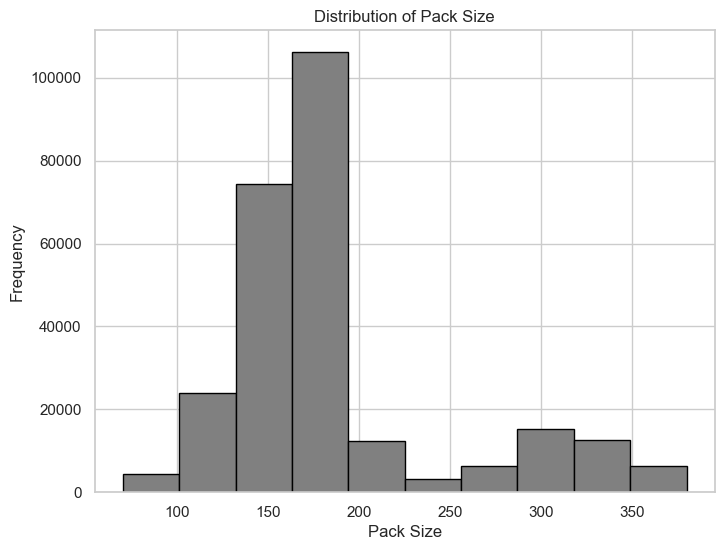

In [93]:
# PLot the histogram for PACK_SIZE:
plt.figure(figsize=(8,6))
plt.hist(data['PACK_SIZE'],bins=10, color='gray',edgecolor='black')
plt.title('Distribution of Pack Size', fontsize=12)
plt.xlabel('Pack Size', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [95]:
# Extract brand names :
data['BRAND']=data['PROD_NAME'].str.extract(r'(\S+)', expand=False)
brand_counts=data['BRAND'].value_counts().sort_values(ascending=False)
brand_counts

BRAND
Kettle        41288
Smiths        28860
Pringles      25102
Doritos       24962
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Old            9324
Tyrrells       6442
Grain          6272
Natural        6050
Red            5885
Cheezels       4603
CCs            4551
Woolworths     4437
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64

In [97]:
# Clean brand name
data.loc[data['BRAND']=='RED', 'BRAND']='RRD'
data.loc[data['BRAND']=='SNBTS', 'BRAND']='SUNBITES'
data.loc[data['BRAND']=='INFZNS', 'BRAND']='INFUZIONS'
data.loc[data['BRAND']=='WW', 'BRAND']='WOOLWORTHS'
data.loc[data['BRAND']=='SMITH', 'BRAND']='SMITHS'
data.loc[data['BRAND']=='NCC', 'BRAND']='NATURAL'
data.loc[data['BRAND']=='DORITO', 'BRAND']='DORITOS'
data.loc[data['BRAND']=='GRAIN', 'BRAND']='GRNWVES'

In [99]:
# Step 1: Group by 'BRAND' and count occurrences
brand_counts = data.groupby('BRAND').size().reset_index(name='N')
brand_counts_sorted = brand_counts.sort_values(by='BRAND')
brand_counts_sorted

,BRAND,N
0,Burger,1564
1,CCs,4551
2,Cheetos,2927
3,Cheezels,4603
4,Cobs,9693
5,Dorito,3185
6,Doritos,24962
7,French,1418
8,Grain,6272
9,GrnWves,1468


In [101]:
customers.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [103]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [105]:
lifestage_counts = customers.groupby('LIFESTAGE').size().reset_index(name='N')
lifestage_counts_sorted = lifestage_counts.sort_values(by='LIFESTAGE', ascending=False)
lifestage_counts_sorted

,LIFESTAGE,N
6,YOUNG SINGLES/COUPLES,14441
5,YOUNG FAMILIES,9178
4,RETIREES,14805
3,OLDER SINGLES/COUPLES,14609
2,OLDER FAMILIES,9780
1,NEW FAMILIES,2549
0,MIDAGE SINGLES/COUPLES,7275


In [107]:
premium_counts = customers.groupby('PREMIUM_CUSTOMER').size().reset_index(name='N')
premium_counts_sorted = premium_counts.sort_values(by='PREMIUM_CUSTOMER', ascending=False)
premium_counts_sorted

,PREMIUM_CUSTOMER,N
2,Premium,18922
1,Mainstream,29245
0,Budget,24470


In [109]:
# Merge transaction data to customer data
merge_data=pd.merge(data, customers, how='left',on='LYLTY_CARD_NBR')
merge_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-19,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-16,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-22,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-19,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-20,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [111]:
# Count rows where LIFESTAGE is null
lifestage_null_count=customers[customers['LIFESTAGE'].isnull()].shape[0]
lifestage_null_count 


0

In [113]:
premium_null_count=customers[customers['PREMIUM_CUSTOMER'].isnull()].shape[0]
premium_null_count

0

<Figure size 1200x600 with 0 Axes>

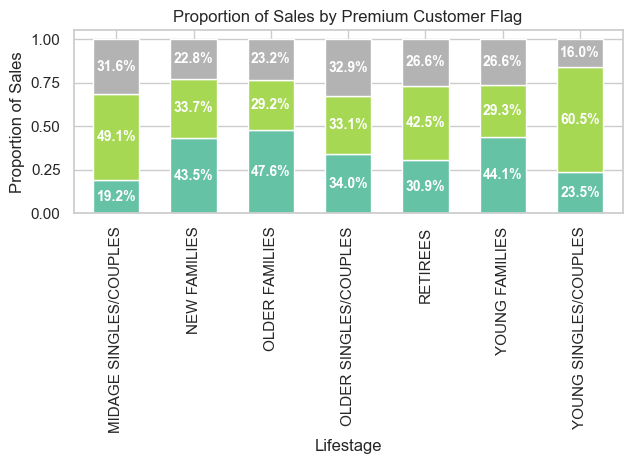

In [117]:


# Assuming merge_data is already defined
sales = merge_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], as_index=False).agg(SALES=('TOT_SALES', 'sum'))

# Create a pivot table for the mosaic plot
pivot_table = sales.pivot_table(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='SALES', fill_value=0)

# Normalize the data to get proportions
mosaic_data = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Create the mosaic plot
plt.figure(figsize=(12, 6))  # Adjust figure size if needed

# Increase the width of the columns
bar_width = 0.6  # Adjust this value as needed
ax = mosaic_data.plot(kind='bar', stacked=True, width=bar_width, colormap='Set2', legend=False)

# Adding labels and title
plt.xlabel('Lifestage')
plt.ylabel('Proportion of Sales')
plt.title('Proportion of Sales by Premium Customer Flag')
plt.xticks(rotation=90)

# Adding text labels for proportions inside the bars
for i in range(mosaic_data.shape[0]):
    for j in range(mosaic_data.shape[1]):
        y_position = mosaic_data.iloc[i, :j+1].sum() - mosaic_data.iloc[i, j] / 2
        # Adding text in the center of each segment
        plt.text(i, y_position, f"{mosaic_data.iloc[i, j] * 100:.1f}%", ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# Optional: Remove legend or position it elsewhere
# ax.legend(title='Premium Customer Flag', loc='lower left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout to fit everything
plt.show()


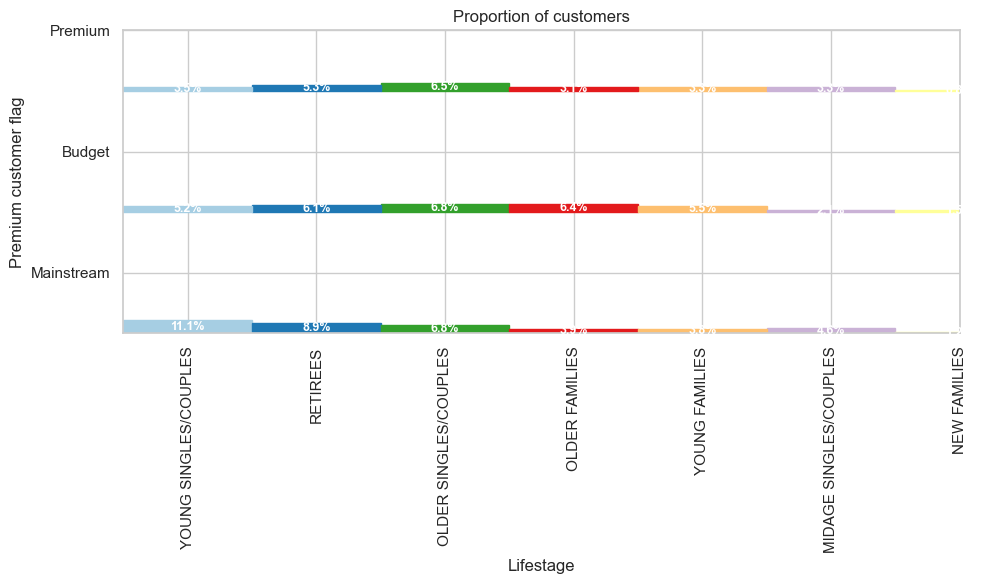

In [119]:
customers = merge_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(CUSTOMERS=('LYLTY_CARD_NBR', 'nunique')).reset_index()
customers = customers.sort_values(by='CUSTOMERS', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))

# Get total customers for proportions
total_sales = customers['CUSTOMERS'].sum()

bar_width = 1.5  
bar_height = 55

# Create a grid of positions for the mosaic tiles
n_lifestages = customers['LIFESTAGE'].nunique()
n_premium = customers['PREMIUM_CUSTOMER'].nunique()

# Plot each tile with the correct position and size
for i, (lifestage, premium) in enumerate(customers[['LIFESTAGE', 'PREMIUM_CUSTOMER']].drop_duplicates().values):
    subset = customers[(customers['LIFESTAGE'] == lifestage) & (customers['PREMIUM_CUSTOMER'] == premium)]
    x = (list(customers['LIFESTAGE'].unique()).index(lifestage))  # x position
    y = (list(customers['PREMIUM_CUSTOMER'].unique()).index(premium))  # y position
    width = 1  # width of each tile
    height = subset['CUSTOMERS'].values[0] / total_sales  # proportionate height

    ax.add_patch(plt.Rectangle((x, y), width, height, label=f"{lifestage}-{premium}",
                               color=plt.cm.Paired(x / len(customers['LIFESTAGE'].unique()))))

    # Label the rectangle with proportion
    ax.text(x + width / 2, y + height / 2,
            f"{round(subset['CUSTOMERS'].values[0] / total_sales * 100, 1)}%",
            ha='center', va='center', fontsize=9, color='white', fontweight='bold')

# Set labels and title
ax.set_xticks(np.arange(n_lifestages) + 0.5)
ax.set_xticklabels(customers['LIFESTAGE'].unique(), rotation=90)
ax.set_yticks(np.arange(n_premium) + 0.5)
ax.set_yticklabels(customers['PREMIUM_CUSTOMER'].unique())
ax.set_xlabel('Lifestage')
ax.set_ylabel('Premium customer flag')
ax.set_title('Proportion of customers')

# Show the plot
plt.tight_layout()
plt.show()

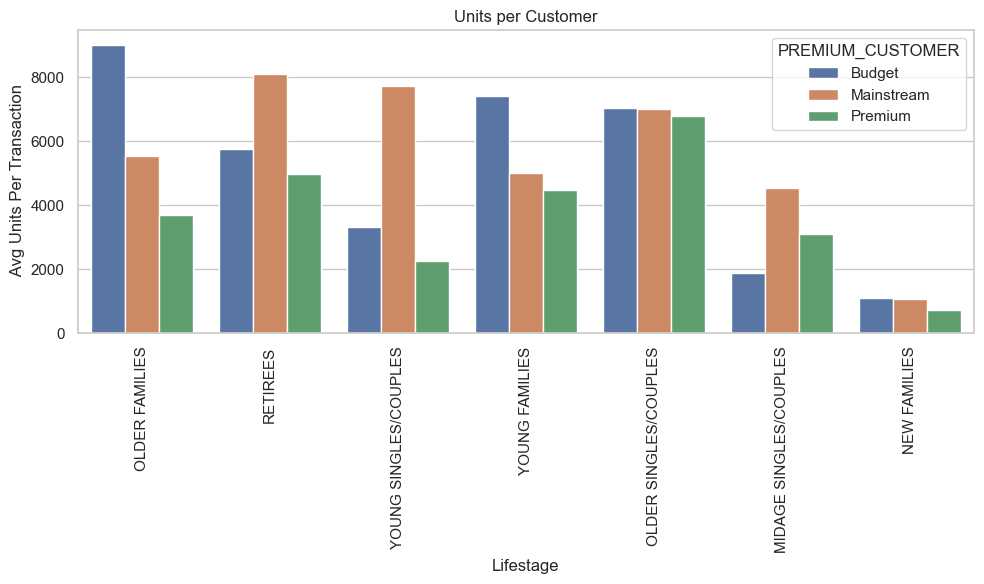

In [121]:
# Calculate average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_units=(
    merge_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(AVG=('PROD_QTY', lambda x: x.sum() / x.nunique()))
    .reset_index()
    .sort_values(by='AVG',ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(data=avg_units, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER', dodge=True)
plt.title('Units per Customer')
plt.xlabel('Lifestage')
plt.ylabel(' Avg Units Per Transaction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

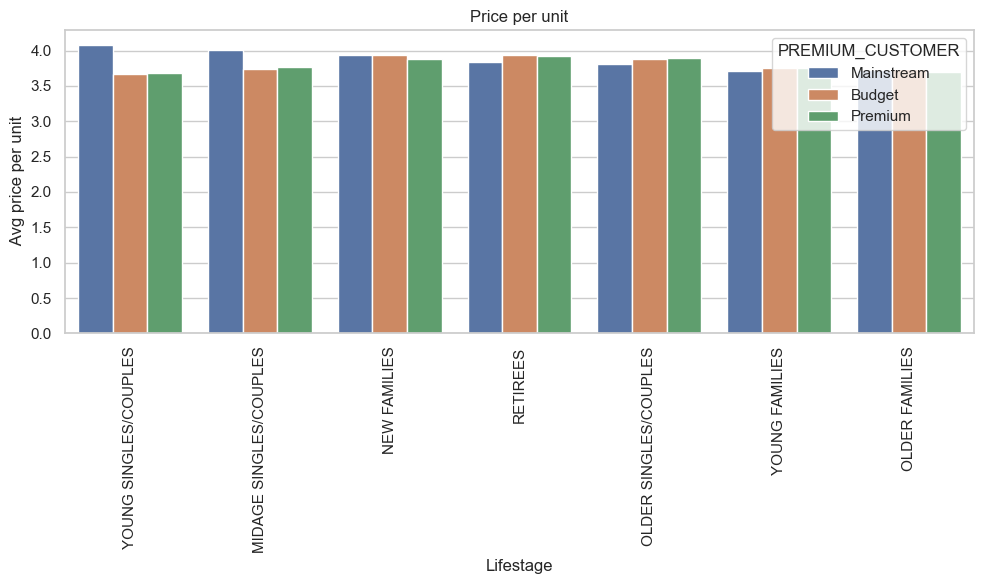

In [123]:
avg_price=(
    merge_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(AVG=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum()))
    .reset_index()
    .sort_values(by='AVG', ascending=False)
)
plt.figure(figsize=(10,6))
sns.barplot(data=avg_price, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER', dodge=True)
plt.title('Price per unit')
plt.xlabel('Lifestage')
plt.ylabel(' Avg price per unit')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [125]:
# Calculate price per unit
data['price'] = data['TOT_SALES'] / data['PROD_QTY']

# Filter data for the two groups
mainstream_prices = data[
    (merge_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) & 
    (merge_data['PREMIUM_CUSTOMER'] == "Mainstream")
]['price']

non_mainstream_prices = data[
    (merge_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) & 
    (merge_data['PREMIUM_CUSTOMER'] != "Mainstream")
]['price']

# Perform independent t-test (one-tailed, alternative = "greater")
t_stat, p_value = ttest_ind(mainstream_prices, non_mainstream_prices, alternative='greater')

# Print results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: 40.8341367879116
P-value: 0.0


In [127]:
# Filter the Mainstream segment
segment1 = data[
    (merge_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) & 
    (merge_data['PREMIUM_CUSTOMER'] == "Mainstream")
]

# Filter the other segment
other = data[
    (merge_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) & 
    (merge_data['PREMIUM_CUSTOMER'] != "Mainstream")
]

# Total quantities for segment1 and other
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate proportions of quantities by brand for segment1
quantity_segment1_by_brand = (
    segment1.groupby('BRAND')
    .agg(targetSegment=('PROD_QTY', lambda x: x.sum() / quantity_segment1))
    .reset_index()
)

# Calculate proportions of quantities by brand for other
quantity_other_by_brand = (
    other.groupby('BRAND')
    .agg(other=('PROD_QTY', lambda x: x.sum() / quantity_other))
    .reset_index()
)

# Merge the two proportions
brand_proportions = pd.merge(quantity_segment1_by_brand, quantity_other_by_brand, on='BRAND')

# Calculate affinity to brand
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']

# Sort by affinity to brand in descending order
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

# Display the result
print(brand_proportions)


         BRAND  targetSegment     other  affinityToBrand
15         Old       0.041790  0.030533         1.368656
12      Kettle       0.183545  0.141276         1.299198
24    Tostitos       0.041887  0.032683         1.281616
25    Twisties       0.042474  0.033155         1.281095
26    Tyrrells       0.027947  0.022801         1.225680
4         Cobs       0.041871  0.035154         1.191082
8        Grain       0.026789  0.022688         1.180767
5       Dorito       0.013647  0.011599         1.176638
6      Doritos       0.103944  0.088432         1.175418
16    Pringles       0.106569  0.091713         1.161984
10   Infuzions       0.045817  0.040189         1.140027
11      Infzns       0.013745  0.012240         1.122989
23       Thins       0.055437  0.051976         1.066577
3     Cheezels       0.017479  0.017143         1.019585
20      Smiths       0.093525  0.113722         0.822402
2      Cheetos       0.008250  0.011655         0.707872
13     NATURAL       0.003978  

In [131]:
quantity_segment1_by_pack = (
    segment1.groupby('PACK_SIZE')
    .agg(targetSegment=('PROD_QTY', lambda x: x.sum() / quantity_segment1))
    .reset_index()
)

# Calculate proportions of quantities by brand for other
quantity_other_by_pack = (
    other.groupby('PACK_SIZE')
    .agg(other=('PROD_QTY', lambda x: x.sum() / quantity_other))
    .reset_index()
)

# Merge the two proportions
pack_proportions = pd.merge(quantity_segment1_by_pack, quantity_other_by_pack, on='PACK_SIZE')

# Calculate affinity to brand
pack_proportions['affinityToBrand'] = pack_proportions['targetSegment'] / pack_proportions['other']

# Sort by affinity to brand in descending order
pack_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

# Display the result
print(pack_proportions)

         BRAND  targetSegment     other  affinityToBrand
15         Old       0.041790  0.030533         1.368656
12      Kettle       0.183545  0.141276         1.299198
24    Tostitos       0.041887  0.032683         1.281616
25    Twisties       0.042474  0.033155         1.281095
26    Tyrrells       0.027947  0.022801         1.225680
4         Cobs       0.041871  0.035154         1.191082
8        Grain       0.026789  0.022688         1.180767
5       Dorito       0.013647  0.011599         1.176638
6      Doritos       0.103944  0.088432         1.175418
16    Pringles       0.106569  0.091713         1.161984
10   Infuzions       0.045817  0.040189         1.140027
11      Infzns       0.013745  0.012240         1.122989
23       Thins       0.055437  0.051976         1.066577
3     Cheezels       0.017479  0.017143         1.019585
20      Smiths       0.093525  0.113722         0.822402
2      Cheetos       0.008250  0.011655         0.707872
13     NATURAL       0.003978  

In [133]:
# Filter rows where PACK_SIZE is 270 and get unique PROD_NAME values
unique_prod_names=data.loc[data['PACK_SIZE']==270, 'PROD_NAME'].unique()
unique_prod_names


array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)